In [2]:
import os
import mne
import mne_bids
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from glob import glob
from mne_bids import BIDSPath, read_raw_bids
from scipy.stats import ttest_rel


In [3]:
print('MNE–Python version', mne.__version__)
print('MNE–BIDS version', mne_bids.__version__)

MNE–Python version 1.9.0
MNE–BIDS version 0.16.0


### define inputs

In [4]:
'''# on Mac Studio Sharepoint
bids_root = os.path.join('/Users/dsj3886/',
                         'Library/CloudStorage/',
                         'OneDrive-NorthwesternUniversity',
                         'Documents - SoundBrain Lab',
                         'Lab Research Projects/',
                         'Experiments/NU_Experiments/',
                         'EAM1/', 'data-bids')
'''
# on MBA local (copied from Sharepoint)
bids_root = os.path.join('/Users/dsj3886/data_local/',
                         'EAM1_local/data-bids')
print('BIDS root directory:', bids_root)

BIDS root directory: /Users/dsj3886/data_local/EAM1_local/data-bids


In [15]:
# outputs
deriv_dir = os.path.join(bids_root, 'derivatives', 'epochs-stimtrack-orig')

# Combine multiple runs (BIDS)

In [6]:
task_list = ['active', 'passive']

In [ ]:
for sub_num in range(2, 35):
    sub_label = f'{sub_num:02d}'

    # initialize an empty dictionary for data
    task_evoked_dict = {}
    event_evoked_dict = {}

    for task_label in task_list:
        print(f'Loading {task_label} data')

        epoch_list = []

        for run_label in range(1,6):
        # load in EEG data
            bids_path = BIDSPath(root=bids_root, datatype='eeg', 
                                 subject=str(sub_label), 
                                 task=task_label, 
                                 run=run_label)
            
            try:
                data = read_raw_bids(bids_path)
                data.load_data()

                # re-reference data to linked mastoid reference
                data_ref = data.set_eeg_reference(ref_channels=['M1', 'M2'])
                
                # filter data
                data_filtered = data_ref.copy().filter(l_freq=65, h_freq=2000)

                # loading events from the stim-track-generated events
                events_fpath = sorted(glob(os.path.join(deriv_dir, 'events-stimtrack') + 
                        f'/*{sub_label}*{task_label}*{run_label}_stimtrack_events.tsv'))[0]
                events_df = pd.read_csv(events_fpath, delimiter='\t') 
                annot = mne.Annotations(onset=events_df.onset, duration=0.170, description=events_df.type)
                data_filtered.set_annotations(annot)
                events_from_annot, event_dict2 = mne.events_from_annotations(data_filtered)
                
                # epoch data based on stimulus events
                epochs = mne.Epochs(data_filtered, 
                                    events=events_from_annot, 
                                    event_id=event_dict2,
                                    on_missing='warn',
                                    picks=['Cz'],
                                    tmin=-0.04, tmax=0.4, 
                                    baseline=[-0.04, 0],
                                    reject=dict(eeg=75e-6)).drop_bad()
                
                epoch_list.append(epochs)

            except:
                print(f"No run {run_label} for task-{task_label}")
        
        try:
            # combine epochs across runs
            all_epochs = mne.concatenate_epochs(epoch_list)
        except IndexError:
            print(f'cannot run for sub-{sub_label} task-{task_label} run-{run_label}')

        try:
            out_base = f'sub-{sub_label}_task-{task_label}_run-all_event-stimtrack_epochs.fif'
            all_epochs.save(os.path.join(deriv_dir, out_base), overwrite=True)
        except:
            continue


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-02/eeg/sub-02_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-02/eeg/sub-02_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-02/eeg/sub-02_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 16826367  =      0.000 ...  1027.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 65 - 2e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_42023/955272693.py:55: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-02/eeg/sub-02_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-02/eeg/sub-02_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-02/eeg/sub-02_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10551295  =      0.000 ...   644.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 65 - 2e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Low

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_42023/955272693.py:55: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-03/eeg/sub-03_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-03/eeg/sub-03_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-03/eeg/sub-03_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 13221887  =      0.000 ...   807.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 65 - 2e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_42023/955272693.py:55: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Not setting metadata
3549 matching events found
Applying baseline correction (mode: mean)
Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-03/eeg/sub-03_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-03/eeg/sub-03_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-03/eeg/sub-03_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10518527  =      0.000 ...   642.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 65 - 2e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_42023/955272693.py:55: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Not setting metadata
3514 matching events found
Applying baseline correction (mode: mean)
Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-04/eeg/sub-04_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-04/eeg/sub-04_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-04/eeg/sub-04_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 17219583  =      0.000 ...  1051.000 secs...
No run 1 for task-active
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-04/eeg/sub-04_task-active_run-2_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-04/eeg/sub-04_tas

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_42023/955272693.py:55: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Loading passive data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-04/eeg/sub-04_task-passive_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-04/eeg/sub-04_task-passive_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-04/eeg/sub-04_task-passive_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 10452991  =      0.000 ...   638.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 65 - 2e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Low

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_42023/955272693.py:55: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs(epoch_list)


Not setting metadata
3566 matching events found
Applying baseline correction (mode: mean)
Loading active data
Extracting EDF parameters from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-05/eeg/sub-05_task-active_run-1_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-05/eeg/sub-05_task-active_run-1_events.tsv.
Reading channel info from /Users/dsj3886/data_local/EAM1_local/data-bids/sub-05/eeg/sub-05_task-active_run-1_channels.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading 0 ... 9142271  =      0.000 ...   558.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 65 - 2e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) met

# Combine participants

In [16]:
# check outputs
sorted(glob(deriv_dir+'/*run-all_event-stimtrack_epochs.fif'))

['/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/epochs-stimtrack-orig/sub-02_task-active_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/epochs-stimtrack-orig/sub-02_task-passive_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/epochs-stimtrack-orig/sub-03_task-active_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/epochs-stimtrack-orig/sub-03_task-passive_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/epochs-stimtrack-orig/sub-04_task-active_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/epochs-stimtrack-orig/sub-04_task-passive_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_local/EAM1_local/data-bids/derivatives/epochs-stimtrack-orig/sub-05_task-active_run-all_event-stimtrack_epochs.fif',
 '/Users/dsj3886/data_lo

In [ ]:
act_pos_avgs = []
act_neg_avgs = []
act_eps = [sorted(glob(deriv_dir+f'/sub-{sub_num:02d}_task-active_run-all_event-stimtrack_epochs.fif') 
                  for sub_num in range(2,35))]
for act_ep in act_eps[0]:
    try:
        sub_active_epochs = mne.read_epochs(act_ep[0], verbose='WARNING')
        act_pos_avgs.append(sub_active_epochs['1'].average())
        act_neg_avgs.append(sub_active_epochs['2'].average())
    except:
        pass

pas_pos_avgs = []
pas_neg_avgs = []
pas_eps = [sorted(glob(deriv_dir+f'/sub-{sub_num:02d}_task-passive_run-all_event-stimtrack_epochs.fif') 
                  for sub_num in range(2,35))]
for pas_ep in pas_eps[0]:
    try:
        sub_passive_epochs = mne.read_epochs(pas_ep[0], verbose='WARNING')
        pas_pos_avgs.append(sub_passive_epochs['1'].average())
        pas_neg_avgs.append(sub_passive_epochs['2'].average())
    except:
        pass


In [18]:
# create a dictionary to hold the average FFRs for each condition
average_FFRs = {'active_positive': act_pos_avgs,
                'active_negative': act_neg_avgs,
                'passive_positive': pas_pos_avgs,
                'passive_negative': pas_neg_avgs}

In [19]:
# check the outputs
average_FFRs['active_positive']

[<Evoked | '1' (average, N=1165), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1776), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1796), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1785), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1744), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1124), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1767), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1763), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1786), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=2301), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '1' (average, N=1691), -0.039978 – 0.40

In [20]:
passive_avgs = [mne.combine_evoked([pas_pos_avgs[x], pas_neg_avgs[x]], weights='nave')
                for x in range(len(pas_pos_avgs))]
active_avgs = [mne.combine_evoked([act_pos_avgs[x], act_neg_avgs[x]], weights='nave')
                for x in range(len(act_pos_avgs))]

In [21]:
active_avgs

[<Evoked | '0.500 × 1 + 0.500 × 2' (average, N=2330.0), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '0.500 × 1 + 0.500 × 2' (average, N=3549.0), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '0.500 × 1 + 0.500 × 2' (average, N=3592.0), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '0.501 × 1 + 0.499 × 2' (average, N=3566.0), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '0.501 × 1 + 0.499 × 2' (average, N=3482.0), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '0.499 × 1 + 0.501 × 2' (average, N=2251.0), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '0.499 × 1 + 0.501 × 2' (average, N=3543.9999999999995), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '0.499 × 1 + 0.501 × 2' (average, N=3530.000000000001), -0.039978 – 0.40002 s, baseline -0.04 – 0 s, 1 ch, ~64 KiB>,
 <Evoked | '0.500 × 1 + 0.500 × 2' (avera

In [22]:
# create grand averages per polarity per condition
pas_pos_grandavg = mne.grand_average(pas_pos_avgs)
pas_neg_grandavg = mne.grand_average(pas_neg_avgs)
act_pos_grandavg = mne.grand_average(act_pos_avgs)
act_neg_grandavg = mne.grand_average(act_neg_avgs)

# create grand averages per condition
passive_grandavg = mne.grand_average(pas_pos_avgs+pas_neg_avgs)
active_grandavg = mne.grand_average(act_pos_avgs+act_neg_avgs)

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


## Combined polarities

In [23]:
evokeds = dict(passive=passive_grandavg, active=active_grandavg)

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_60230/2310340775.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds,


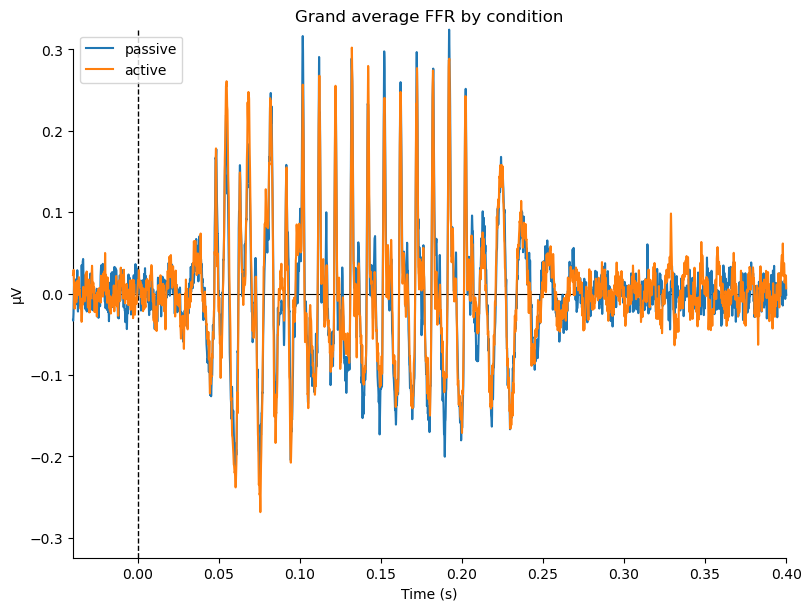

[<Figure size 800x600 with 1 Axes>]

In [24]:
mne.viz.plot_compare_evokeds(evokeds, 
                             title='Grand average FFR by condition',
                             truncate_xaxis=False)

Effective window size : 0.100 (s)
Effective window size : 0.100 (s)
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


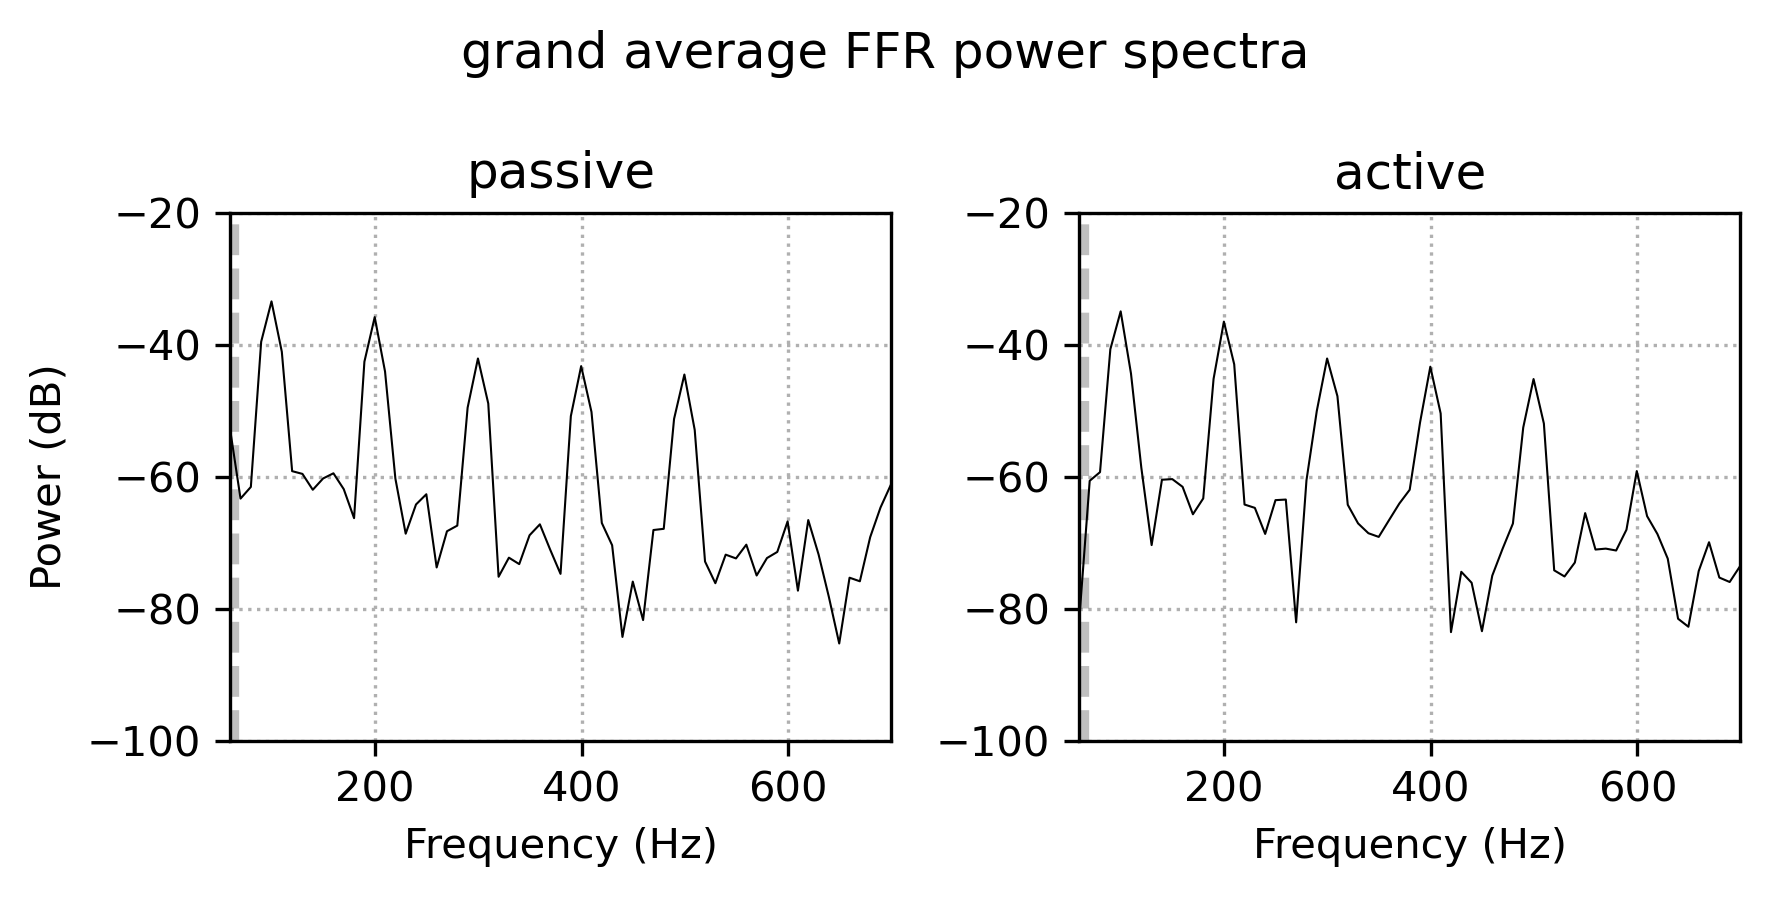

In [25]:
# Power spectra
passive_psd = passive_grandavg.compute_psd(method='welch',
                                           tmin=0.1, tmax=0.2, fmin=50, fmax=700)
active_psd = active_grandavg.compute_psd(method='welch',
                                           tmin=0.1, tmax=0.2, fmin=50, fmax=700)

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=300)
ax = axes.flatten()
passive_psd.plot(axes=ax[0], amplitude=False, average=True, show=False)
active_psd.plot(axes=ax[1], amplitude=False, average=True, show=False)
#active_neg_psd.plot(axes=ax[3], amplitude=False, average=True, show=False)

ax[0].set_ylim([-100, -20])
ax[1].set_ylim([-100, -20])

ax[0].set_title('passive')
ax[1].set_title('active')

ax[0].set_ylabel('Power (dB)')
ax[0].set_xlabel('Frequency (Hz)')
ax[1].set_xlabel('Frequency (Hz)')

fig.suptitle(f'grand average FFR power spectra')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectra.svg')

No baseline correction applied
No baseline correction applied


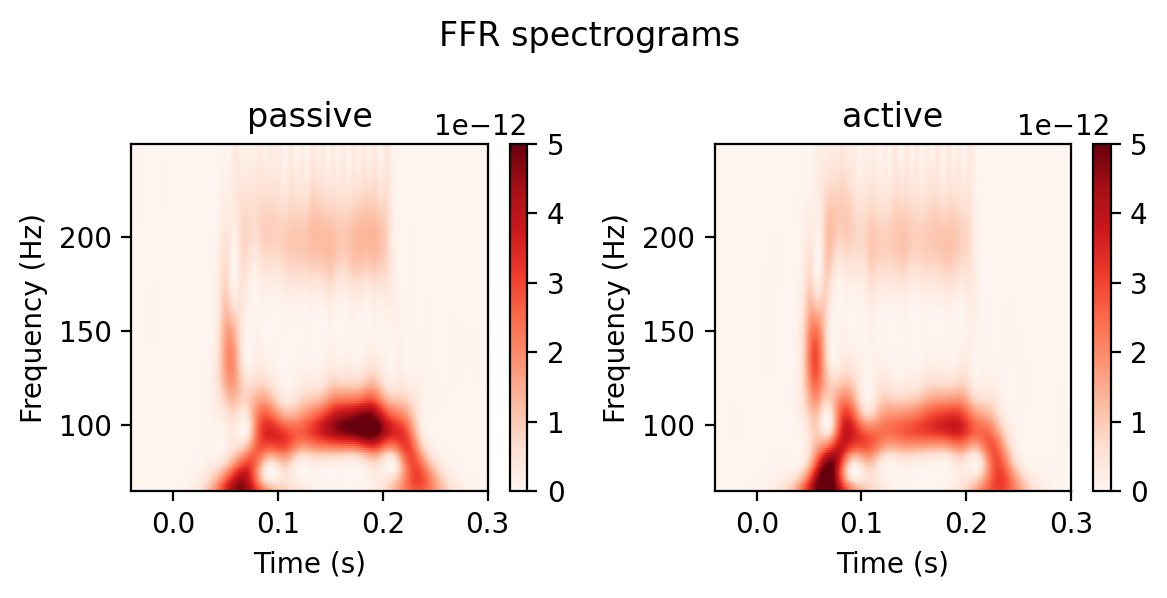

In [26]:
# Spectrograms
frequencies = np.arange(65,250)

passive_power = passive_grandavg.compute_tfr("morlet", freqs=frequencies)
active_power = active_grandavg.compute_tfr("morlet", freqs=frequencies)

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=200)
ax = axes.flatten()
passive_power.plot(axes=ax[0], tmax=0.3, vlim=[0, 5e-12], show=False)
active_power.plot(axes=ax[1], tmax=0.3, vlim=[0, 5e-12], show=False)

ax[0].set_title('passive');
ax[1].set_title('active');


fig.suptitle(f'FFR spectrograms')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_spectrograms.svg')

No baseline correction applied
No baseline correction applied


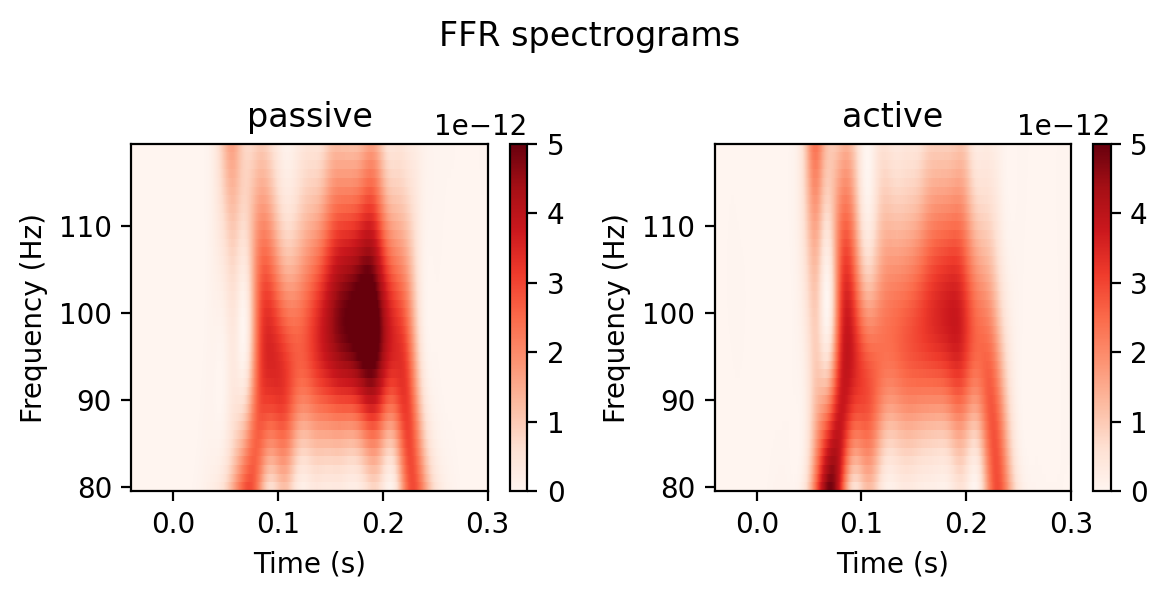

In [27]:
# Spectrograms – smaller frequency range
frequencies = np.arange(80,120)

passive_power = passive_grandavg.compute_tfr("morlet", freqs=frequencies)
active_power = active_grandavg.compute_tfr("morlet", freqs=frequencies)

fig, axes = plt.subplots(1, 2, figsize=(6,3), dpi=200)
ax = axes.flatten()
passive_power.plot(axes=ax[0], tmax=0.3, vlim=[0, 5e-12], show=False)
active_power.plot(axes=ax[1], tmax=0.3, vlim=[0, 5e-12], show=False)

ax[0].set_title('passive');
ax[1].set_title('active');


fig.suptitle(f'FFR spectrograms')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_freq-80-120_spectrograms.svg')

### Power stats

In [28]:
def compute_power(avg_evoked, f_low=90, f_high=110, t_low=0.1, t_high=0.2):
    # Compute the spectrogram (time-frequency representation)
    power = mne.time_frequency.tfr_multitaper(avg_evoked, 
                                            freqs=np.arange(f_low, f_high, 1), 
                                            n_cycles=2, time_bandwidth=4.0,
                                            average=True, return_itc=False)

    # Select the time and frequency bands
    time_mask = (power.times >= t_low) & (power.times <= t_high)
    freq_mask = (power.freqs >= f_low) & (power.freqs <= f_high)

    # Extract the power within the specified bands
    selected_power = power.data[:, freq_mask, :][:, :, time_mask]

    # Average power over the selected time and frequency bands
    average_power = selected_power.mean(axis=2).mean(axis=1)[0]
    return average_power

In [80]:
f_low=90
f_high=110
t_low=0.1
t_high=0.2

# Extract power for passive condition
pas_power_list = []
for evk in passive_avgs:
    power = compute_power(evk, f_low=f_low, f_high=f_high, t_low=t_low, t_high=t_high)
    pas_power_list.append(power)

# Extract power for active condition
act_power_list = []
for evk in active_avgs:
    power = compute_power(evk, f_low=f_low, f_high=f_high, t_low=t_low, t_high=t_high)
    act_power_list.append(power)

# Create a DataFrame for power values
power_dict = {'passive': pas_power_list,  
              'active': act_power_list}
power_df = pd.DataFrame(power_dict)

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper

In [77]:
# check the power dataframe
power_df.head()

,passive,active
0,1.505680e-12,2.218058e-12
1,5.107736e-13,4.272768e-13
2,1.263318e-11,1.414383e-11
3,1.558277e-12,1.711079e-12
4,1.722924e-11,1.984113e-11


In [78]:
# Compute the mean power for each condition
power_pass_mean = power_df['passive'].mean()
power_act_mean = power_df['active'].mean()
print(f'Mean passive power: {power_pass_mean}')
print(f'Mean active power: {power_act_mean}')

# Perform paired t-test
t_stat, p_value = ttest_rel(power_df['passive'], power_df['active'])
print(f"power t-statistic: {t_stat:.03f}, p-value: {p_value:.03f}")

Mean passive power: 6.435027655249887e-12
Mean active power: 1.0301144908521856e-11
power t-statistic: -1.108, p-value: 0.277


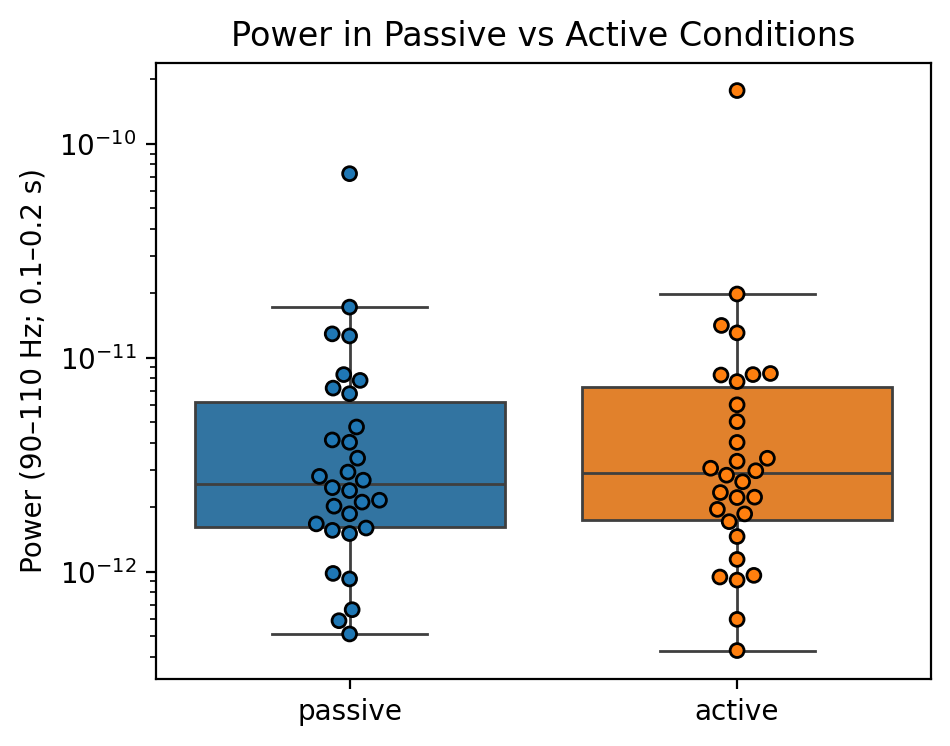

In [99]:
# Plotting the power values
plt.figure(figsize=(5,4), dpi=200)
sns.swarmplot(power_df, edgecolor='k', linewidth=1, log_scale=True)
sns.boxplot(power_df, fliersize=0)
plt.ylabel(f'Power ({f_low}–{f_high} Hz; {t_low}–{t_high} s)')
plt.title('Power in Passive vs Active Conditions')
plt.show()

### RMS SNR stats

In [42]:
from numpy import mean, sqrt, square

In [43]:
# helper function to compute RMS SNR
def compute_rms(evoked):
    baseline_ind_bounds = evoked.time_as_index(evoked.baseline)
    response_ind_bounds = evoked.time_as_index([0.100, 0.200])

    evoked_baseline = evoked.data[0,baseline_ind_bounds[0]:baseline_ind_bounds[1]]
    evoked_response = evoked.data[0,response_ind_bounds[0]:response_ind_bounds[1]]
    rms_baseline = sqrt(mean(square(evoked_baseline)))
    rms_response = sqrt(mean(square(evoked_response)))

    rms_snr = rms_response / rms_baseline
    return rms_snr

In [44]:
# compute RMS SNR for each condition for the grand average
task_evoked_dict = {}
task_evoked_dict['passive'] = passive_grandavg
task_evoked_dict['active']  = active_grandavg

for sx, stim in enumerate(task_evoked_dict):
    s_evoked = task_evoked_dict[stim]
    rms_snr = compute_rms(s_evoked)

    print(f'{stim} RMS SNR: {rms_snr:.04f}')


passive RMS SNR: 6.9497
active RMS SNR: 7.5076


In [45]:
# compute RMS SNR for each condition
pas_rms_list = []
for evk in pas_pos_avgs+pas_neg_avgs:
    rms_snr = compute_rms(evk)
    pas_rms_list.append(rms_snr)

act_rms_list = []
for evk in act_pos_avgs+act_neg_avgs:
    rms_snr = compute_rms(evk)
    act_rms_list.append(rms_snr)

# Create a DataFrame for RMS SNR values
rms_dict = {'passive': pas_rms_list,  
              'active': act_rms_list}
rms_df = pd.DataFrame(rms_dict)


In [46]:
# calculate mean RMS SNR for each condition
rms_pass_mean = rms_df['passive'].mean()
rms_act_mean = rms_df['active'].mean()
print(f'Mean passive RMS ratio: {rms_pass_mean:.03f}')
print(f'Mean active RMS ratio: {rms_act_mean:.03f}')

# Perform paired t-test
t_stat, p_value = ttest_rel(rms_dict['passive'], rms_dict['active'])
print(f"RMS ratio t-statistic: {t_stat:.03f}, p-value: {p_value:.03f}")

Mean passive RMS ratio: 2.699
Mean active RMS ratio: 2.676
RMS ratio t-statistic: 0.232, p-value: 0.818


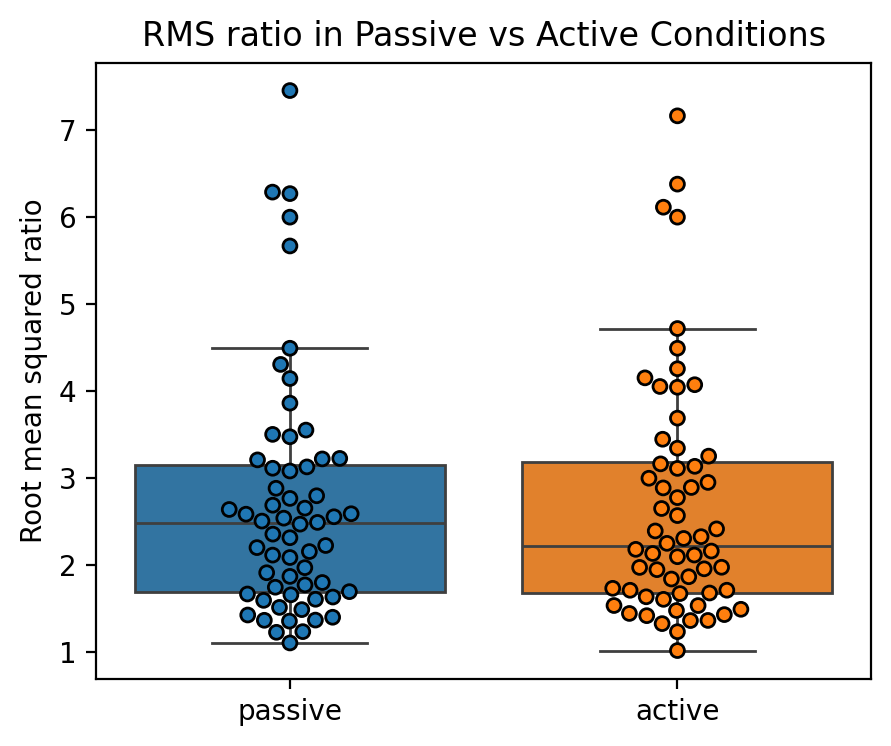

In [47]:
# Plotting the RMS values
plt.figure(figsize=(5,4), dpi=200)
sns.swarmplot(rms_df, edgecolor='k', linewidth=1)
sns.boxplot(rms_df, fliersize=0)
plt.ylabel('Root mean squared ratio')
plt.title('RMS ratio in Passive vs Active Conditions')
plt.show()

### Peak stats

In [87]:
tmin = 0.05
tmax = 0.15

# Extract power for passive condition
pas_peak_lat_list = []
pas_peak_amp_list = []
for evk in passive_avgs:
    peak = evk.get_peak(tmin=tmin, tmax=tmax, return_amplitude=True)
    pas_peak_lat_list.append(peak[1])
    pas_peak_amp_list.append(peak[2])

# Extract power for active condition
act_peak_lat_list = []
act_peak_amp_list = []
for evk in active_avgs:
    peak = evk.get_peak(tmin=0.05, tmax=0.15, return_amplitude=True)
    act_peak_lat_list.append(peak[1])
    act_peak_amp_list.append(peak[2])

# Create a DataFrame for power values
peak_lat_dict = {'passive': pas_peak_lat_list,  
              'active': act_peak_lat_list}
peak_df = pd.DataFrame(peak_lat_dict)

In [83]:
passive_avgs[0].pick('Cz').get_peak()

('Cz', 0.10205078125)

In [84]:
peak_df

,passive,active
0,0.102051,0.122437
1,0.074585,0.075012
2,0.142517,0.142578
3,0.091370,0.091431
4,0.149231,0.142517
5,0.112000,0.111938
6,0.132141,0.132019
7,0.131653,0.132141
8,0.131897,0.111938
9,0.101685,0.101624


In [90]:
# Compute the mean peak for each condition
peak_pass_mean = peak_df['passive'].mean()
peak_act_mean = peak_df['active'].mean()
print(f'Mean passive peak latency: {peak_pass_mean:.03f} ms')
print(f'Mean active peak latency: {peak_act_mean:.03f} ms')

# Perform paired t-test
t_stat, p_value = ttest_rel(peak_df['passive'], peak_df['active'])
print(f"peak t-statistic: {t_stat:.03f}\npeak p-value: {p_value:.05f}")

Mean passive peak latency: 0.107 ms
Mean active peak latency: 0.109 ms
peak t-statistic: -0.470
peak p-value: 0.64199


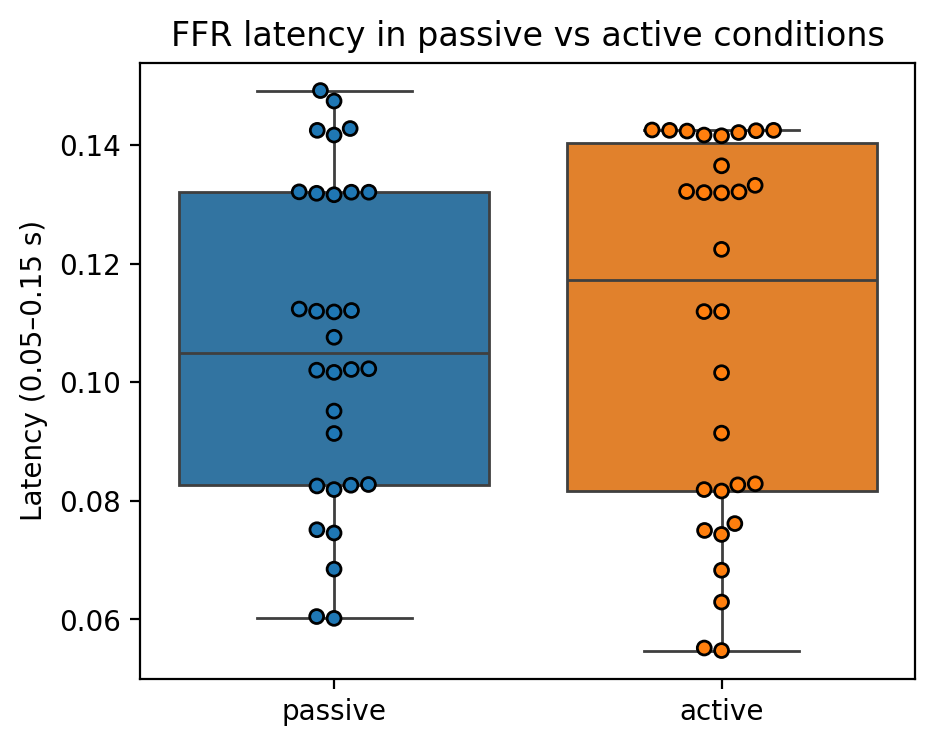

In [100]:
# Plotting the power values
plt.figure(figsize=(5,4), dpi=200)
sns.swarmplot(peak_df, edgecolor='k', linewidth=1)
sns.boxplot(peak_df, fliersize=0)
#plt.ylim([0.0, 0.15])
plt.ylabel(f'Latency ({tmin}–{tmax} s)')
plt.title('FFR latency in passive vs active conditions')

plt.show()

### Power stats

In [ ]:
def compute_power(avg_evoked, f_low=90, f_high=110, t_low=0.1, t_high=0.2):
    # Compute the spectrogram (time-frequency representation)
    power = mne.time_frequency.tfr_multitaper(avg_evoked, 
                                            freqs=np.arange(f_low, f_high, 1), 
                                            n_cycles=2, 
                                            time_bandwidth=4.0,
                                            average=True, 
                                            return_itc=False)

    # Select the time and frequency bands
    time_mask = (power.times >= t_low) & (power.times <= t_high)
    freq_mask = (power.freqs >= f_low) & (power.freqs <= f_high)

    # Extract the power within the specified bands
    selected_power = power.data[:, freq_mask, :][:, :, time_mask]

    # Average power over the selected time and frequency bands
    average_power = selected_power.mean(axis=2).mean(axis=1)[0]
    return average_power

#### motor response

In [ ]:
f_low=4
f_high=30
t_low=-0.04
t_high=0.1

# Extract power for passive condition
pas_power_list = []
for evk in passive_avgs:
    power = compute_power(evk, f_low=f_low, f_high=f_high, t_low=t_low, t_high=t_high)
    pas_power_list.append(power)

# Extract power for active condition
act_power_list = []
for evk in active_avgs:
    power = compute_power(evk, f_low=f_low, f_high=f_high, t_low=t_low, t_high=t_high)
    act_power_list.append(power)

# Create a DataFrame for power values
power_dict = {'passive': pas_power_list,  
              'active': act_power_list}
power_df = pd.DataFrame(power_dict)

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
NOTE: tfr_multitaper

## Individual polarities

In [48]:
evokeds_polar = dict(passive_positive=pas_pos_avgs, 
                     passive_negative=pas_neg_avgs, 
                     active_positive=act_pos_avgs, 
                     active_negative=act_neg_avgs)

/var/folders/5g/l5zc58vs5y17h1lbzp_7g3_40000gq/T/ipykernel_60230/2459182516.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(evokeds_polar,


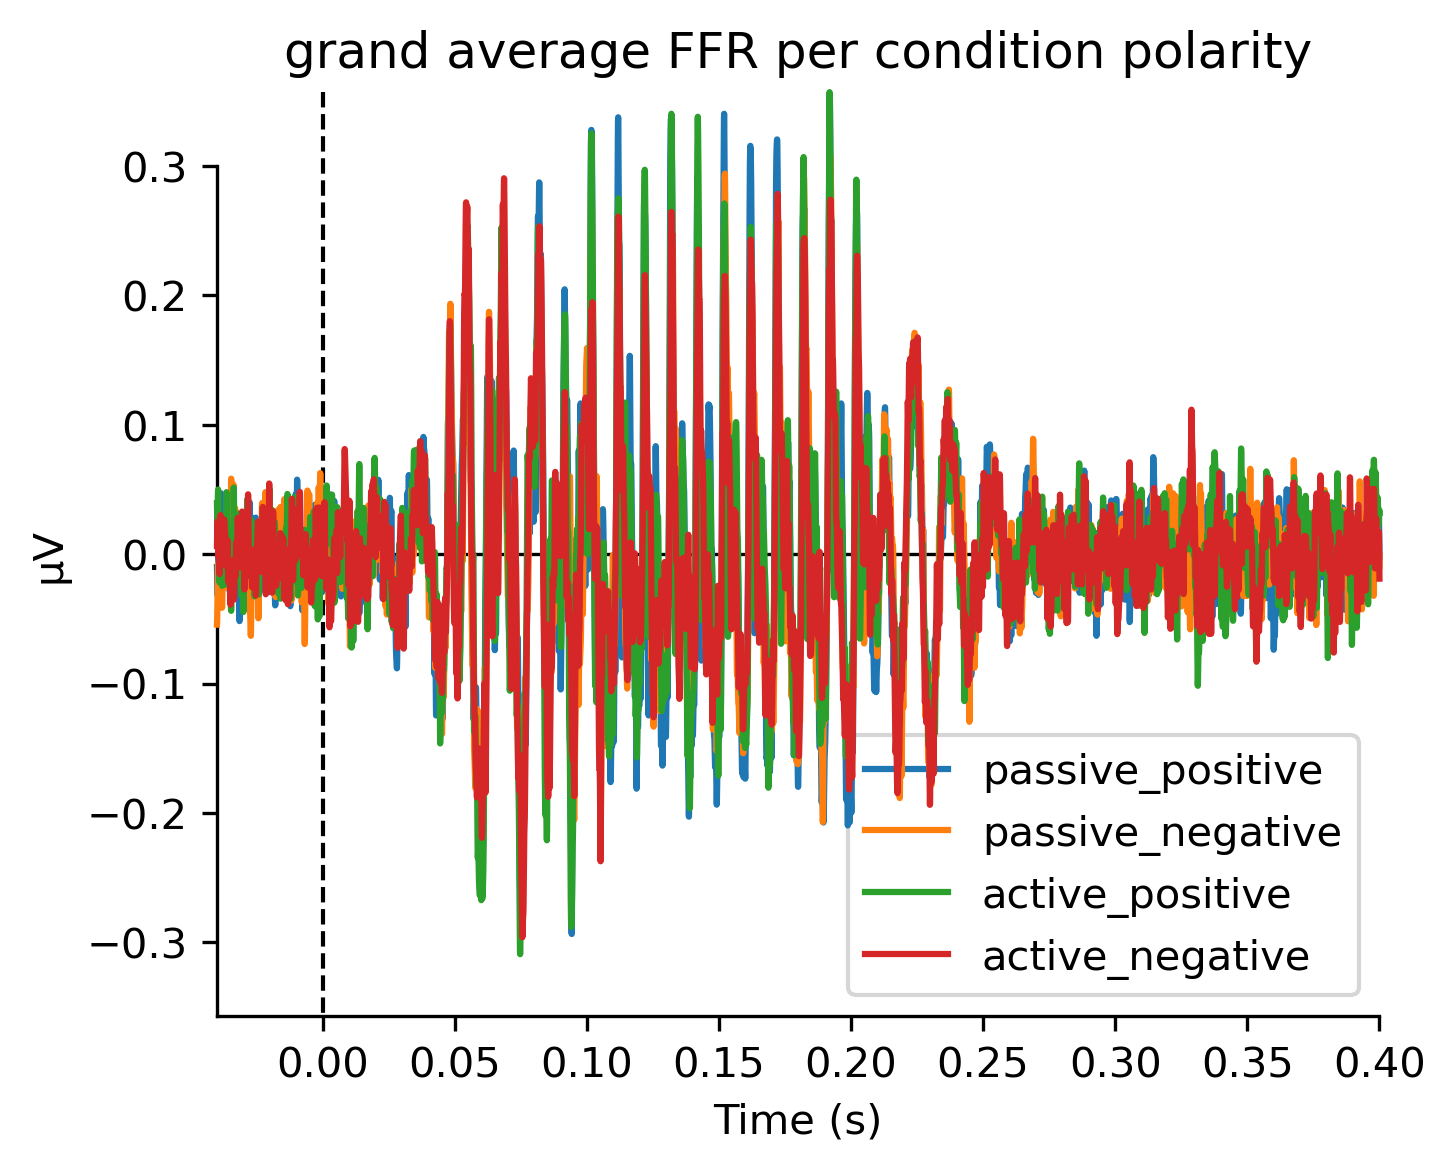

[<Figure size 1500x1200 with 1 Axes>]

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(5,4), dpi=300)
mne.viz.plot_compare_evokeds(evokeds_polar, 
                             #[pas_pos_grandavg,pas_neg_grandavg,act_pos_grandavg, act_neg_grandavg],
                             ci=False,
                             truncate_xaxis=False,
                             legend='lower right',
                             title='grand average FFR per condition polarity',
                             axes=ax)

Text(0.5, 1.0, 'active/negative')

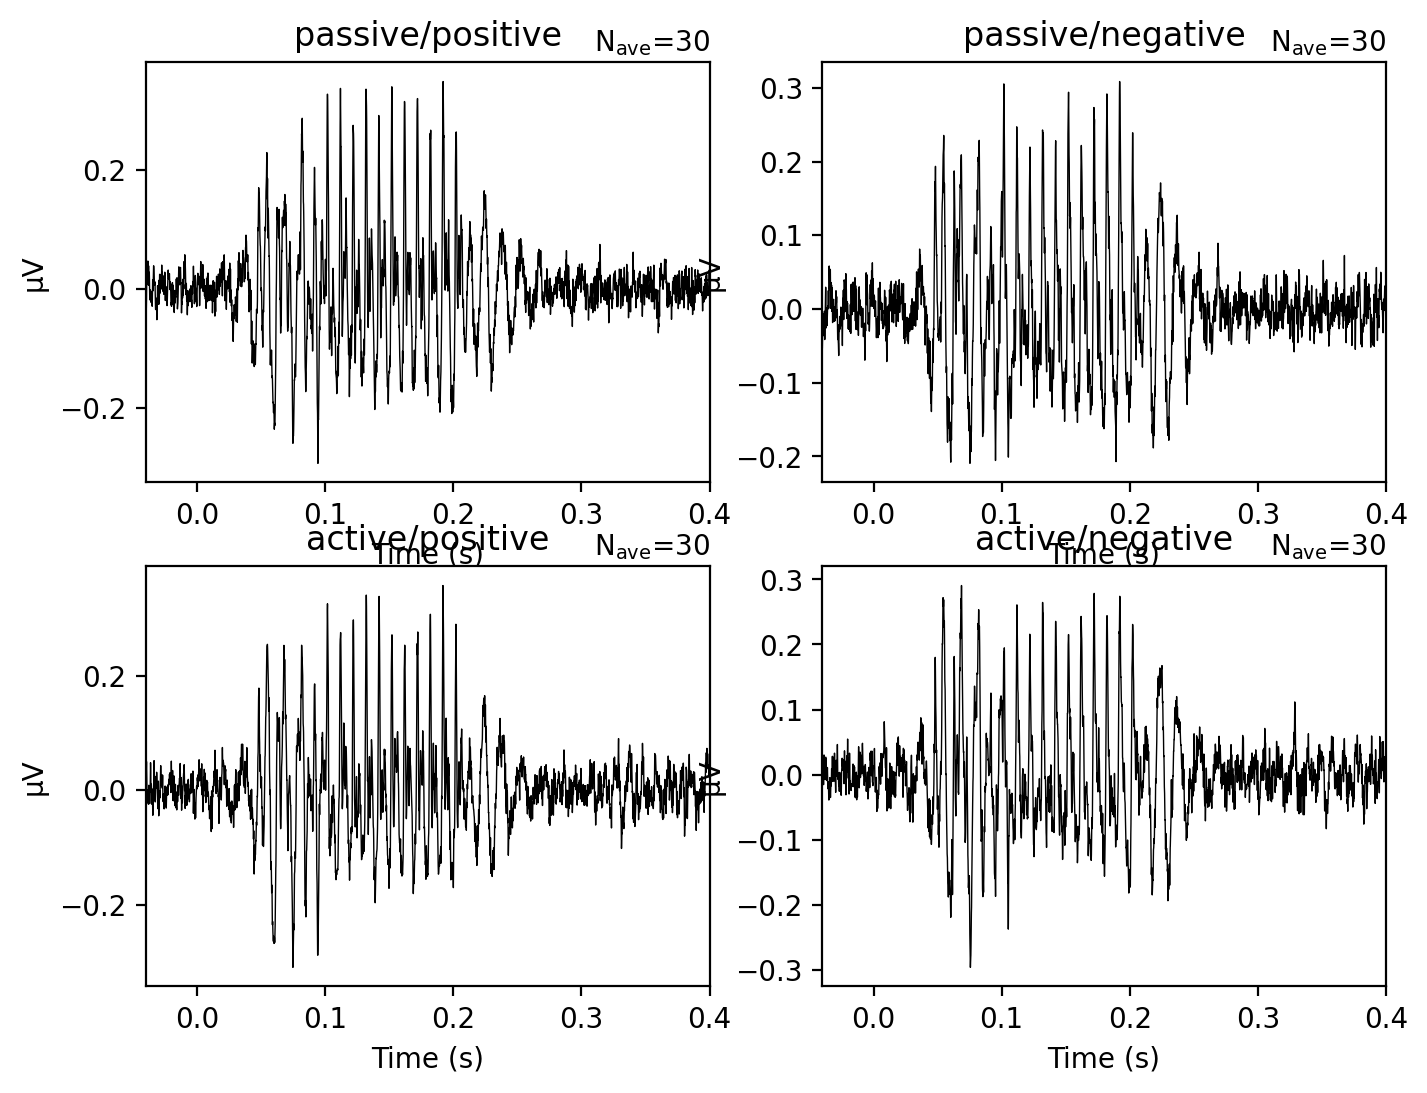

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
pas_pos_grandavg.plot(axes=ax[0], selectable=False, show=False)
pas_neg_grandavg.plot(axes=ax[1], selectable=False, show=False)
act_pos_grandavg.plot(axes=ax[2], selectable=False, show=False)
act_neg_grandavg.plot(axes=ax[3], selectable=False, show=False)

ax[0].set_title('passive/positive')
ax[1].set_title('passive/negative')
ax[2].set_title('active/positive')
ax[3].set_title('active/negative')

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


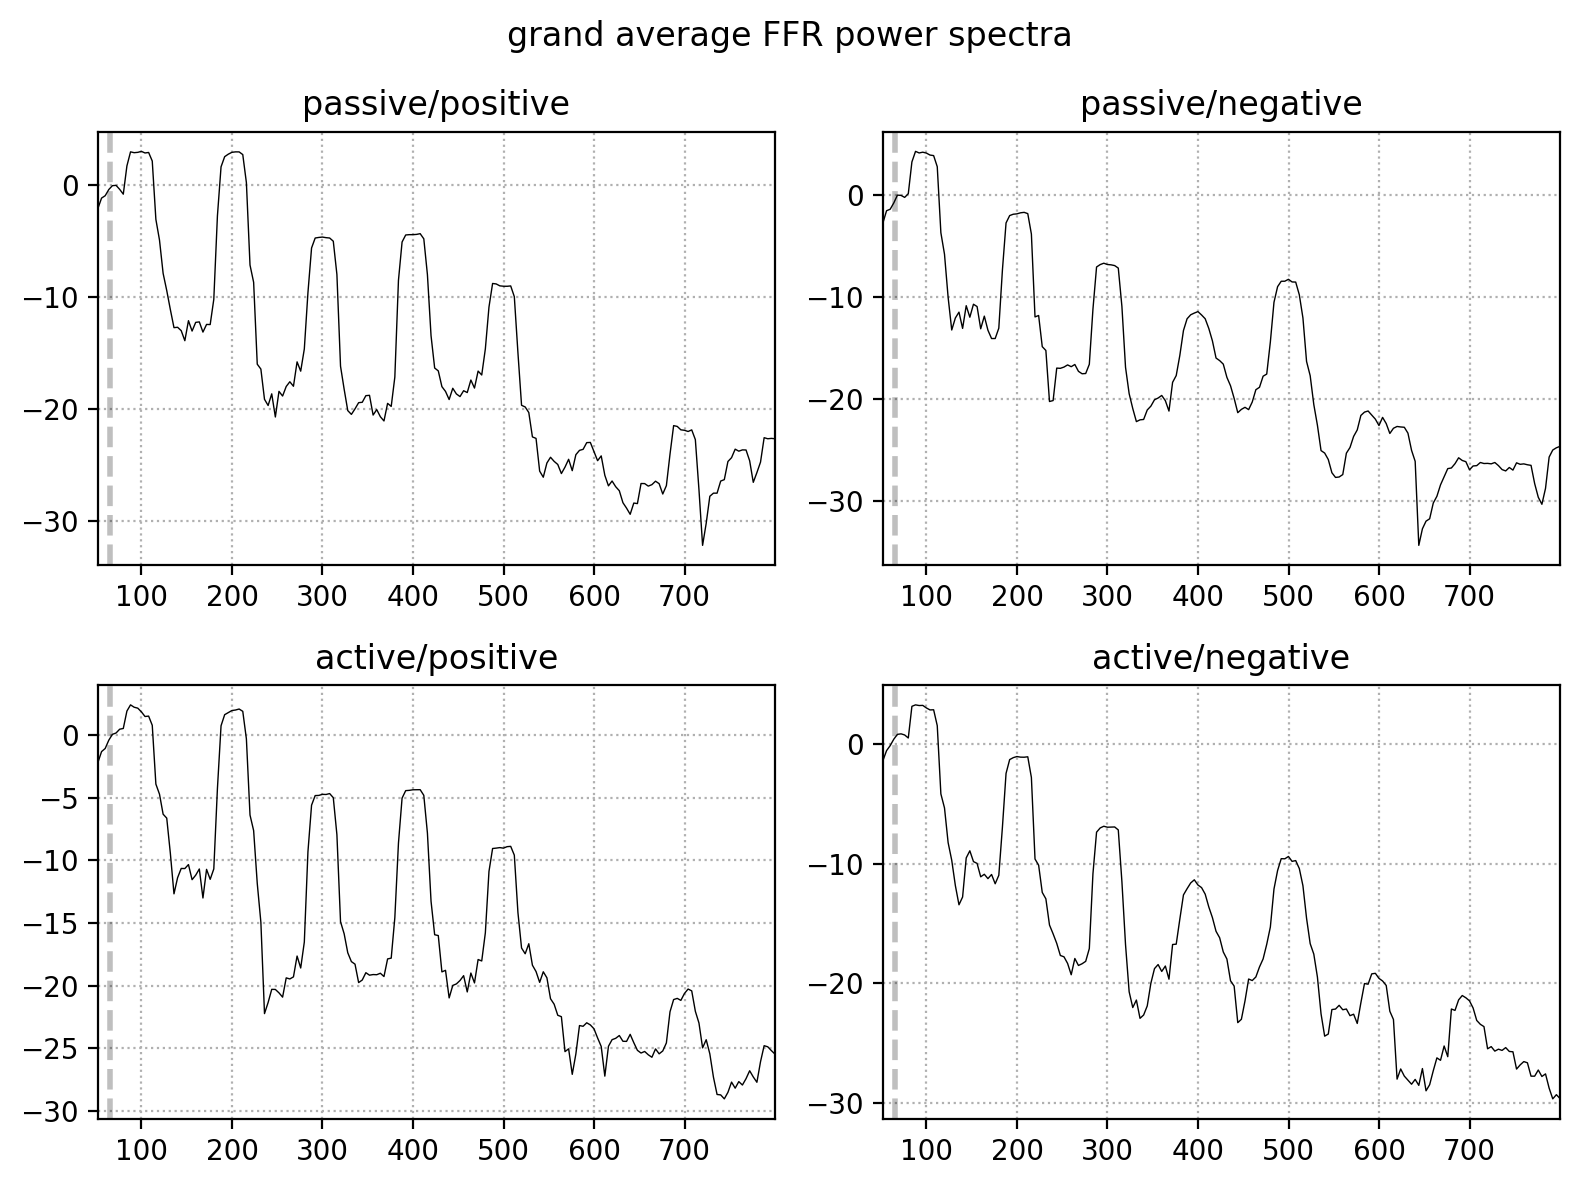

In [51]:
# Power spectra
passive_pos_psd = pas_pos_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
passive_neg_psd = pas_neg_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
active_pos_psd = act_pos_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)
active_neg_psd = act_neg_grandavg.compute_psd(tmin=0.05, tmax=0.300, fmin=50, fmax=800)

fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
passive_pos_psd.plot(axes=ax[0], amplitude=False, average=True, show=False)
passive_neg_psd.plot(axes=ax[1], amplitude=False, average=True, show=False)
active_pos_psd.plot(axes=ax[2], amplitude=False, average=True, show=False)
active_neg_psd.plot(axes=ax[3], amplitude=False, average=True, show=False)

ax[0].set_title('passive/positive')
ax[1].set_title('passive/negative')
ax[2].set_title('active/positive')
ax[3].set_title('active/negative')

fig.suptitle(f'grand average FFR power spectra')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectra.svg')

No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


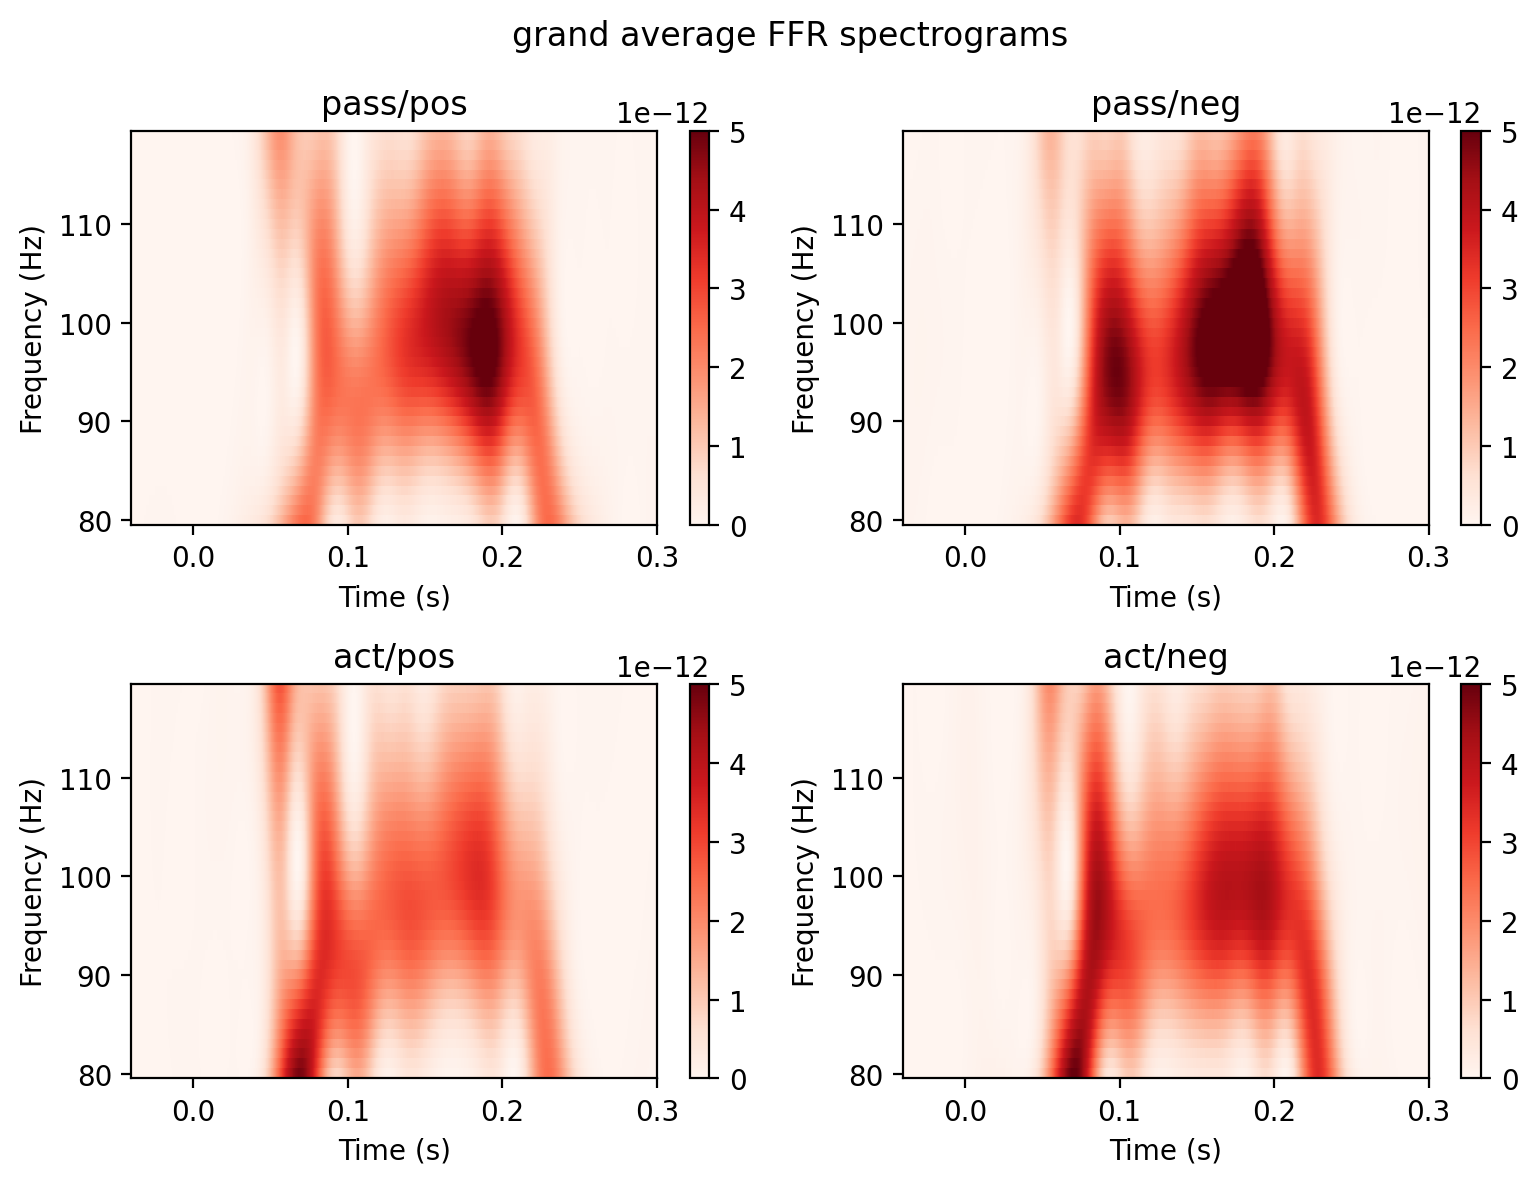

In [52]:
# Spectrograms
passive_pos_power = pas_pos_grandavg.compute_tfr("morlet", freqs=frequencies)
passive_neg_power = pas_neg_grandavg.compute_tfr("morlet", freqs=frequencies)
active_pos_power  = act_pos_grandavg.compute_tfr("morlet", freqs=frequencies)
active_neg_power  = act_neg_grandavg.compute_tfr("morlet", freqs=frequencies)

fig, axes = plt.subplots(2, 2, figsize=(8,6), dpi=200)
ax = axes.flatten()
passive_pos_power.plot(axes=ax[0], tmax=0.3, vlim=[0, 5e-12], show=False)
passive_neg_power.plot(axes=ax[1], tmax=0.3, vlim=[0, 5e-12], show=False)
active_pos_power.plot(axes=ax[2], tmax=0.3, vlim=[0, 5e-12], show=False)
active_neg_power.plot(axes=ax[3], tmax=0.3, vlim=[0, 5e-12], show=False)

ax[0].set_title('pass/pos');
ax[1].set_title('pass/neg');
ax[2].set_title('act/pos');
ax[3].set_title('act/neg');

fig.suptitle(f'grand average FFR spectrograms')

fig.tight_layout()
plt.show()
#plt.savefig(f'sub-{sub_label}_polarity-single_spectra.svg')

# [IN PREP] QA and metrics

## Response-response correlations

In [ ]:
from scipy.signal import correlate
from scipy.stats import pearsonr

In [54]:
r_vals = []
p_vals = []
# loop through the active averages and compute Pearson's r and p-values
# between active and passive conditions for each subject
for sx in range(len(active_avgs)):
    on_off = active_avgs[sx].time_as_index([0.050, 0.200])

    res = spearmanr(active_avgs[sx].data[0, on_off[0]:on_off[1]],
                passive_avgs[sx].data[0, on_off[0]:on_off[1]],)
    r_vals.append(res[0])
    p_vals.append(res[1])

Mean r = 0.775, SD = 0.142


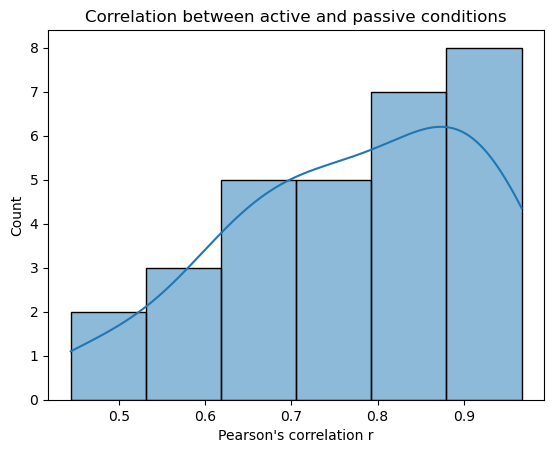

In [75]:
sns.histplot(r_vals, kde=True)
plt.xlabel("Pearson's correlation r")
plt.title('Correlation between active and passive conditions')
print(f"Mean r = {np.mean(r_vals):.3f}, SD = {np.std(r_vals):.3f}")

### Are active and passive correlated?

In [67]:
from scipy.stats import ttest_1samp
from numpy import arctanh

z_vals = arctanh(r_vals)  # Fisher z-transform
t_stat, p_val = ttest_1samp(z_vals, 0)  # Null: mean r = 0

print(f"t = {t_stat:.2f}, p = {p_val:.5f}")


t = 14.54, p = 0.00000


### Equivalence testing (for evidence of no meaningful difference)

In [68]:
from statsmodels.stats.weightstats import DescrStatsW, ttost_paired

# Get the difference scores per timepoint, then average across time
active_data = [active_avgs[sx].data[0, on_off[0]:on_off[1]] for sx in range(len(active_avgs))]
passive_data = [passive_avgs[sx].data[0, on_off[0]:on_off[1]] for sx in range(len(active_avgs))]


active_means = np.array(active_data).mean(axis=1)
passive_means = np.array(passive_data).mean(axis=1)

# TOST: are diffs within a negligible effect size (e.g., ±0.1)?
low_eq_bound = -0.1
high_eq_bound = 0.1
result = ttost_paired(active_means, passive_means, low_eq_bound, high_eq_bound)
#print(f"TOST p-values: {res_lower:.3e}, {res_upper:.3e}")


In [69]:
# https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.ttost_paired.html
result

(2.6830292207110385e-209,
 (76596833.35291995, 2.683028028341316e-209, 29.0),
 (-76596832.1791083, 2.6830292207110385e-209, 29.0))

### Cross-correlations [IN PREP]

Best lag: -2 samples (-0.002 seconds)


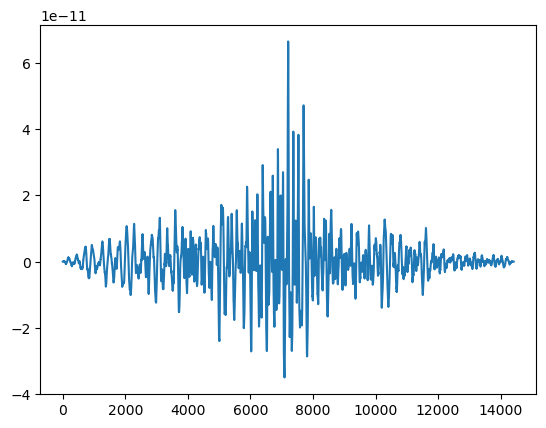

In [63]:
corr_array = correlate(active_avgs[0].data[0],
                        passive_avgs[0].data[0],
                        mode='full', method='fft'
                        )
plt.plot(corr_array)

lags = np.arange(-len(active_avgs[0].data[0])+1, len(active_avgs[0].data[0]))
best_lag = lags[np.argmax(corr_array)]
print(f"Best lag: {best_lag} samples ({best_lag / 1000:.3f} seconds)")


## [IN PREP] Autocorrelation

In [17]:
import statsmodels.api as sm

In [18]:
acf, confint = sm.tsa.stattools.acf(passive_grandavg.data[0], 
                                    nlags=len(passive_grandavg.data[0])-1,
                                    alpha=.05)

NameError: name 'passive_grandavg' is not defined

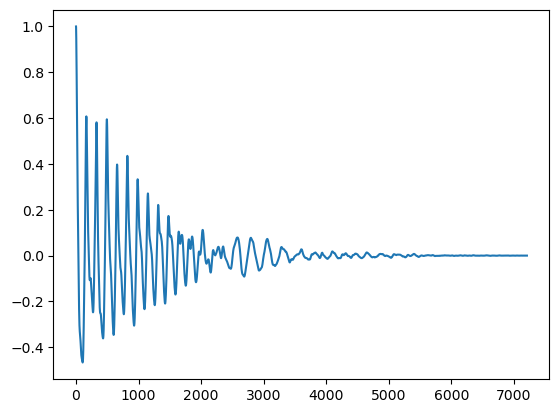

In [169]:
plt.plot(acf)
plt.show()

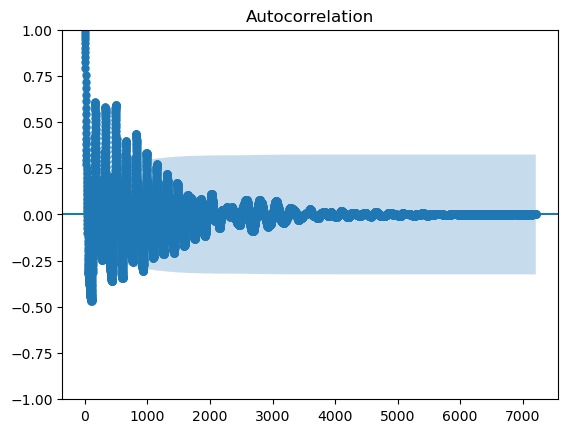

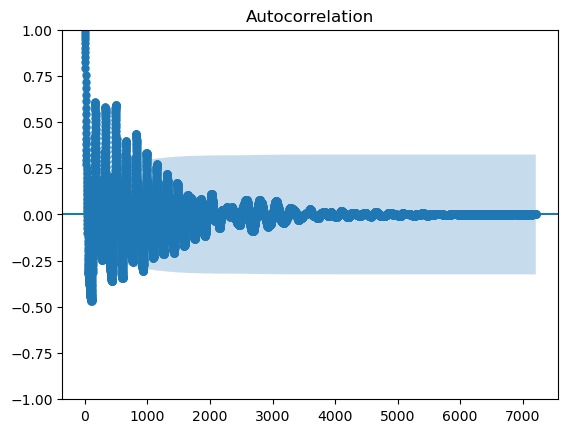

In [171]:
sm.graphics.tsa.plot_acf(passive_grandavg.data[0], 
                         lags=len(passive_grandavg.data[0])-1, 
                         zero=False,)

## [IN PREP] Stimulus–response correlations


In [163]:
data.pick(['Erg1'])

NameError: name 'data' is not defined

In [172]:
# epoch data based on stimulus events
stim_epochs = mne.Epochs(data_filtered, 
                    events, 
                    event_id=event_dict,
                    picks=['Erg1'],
                    tmin=-0.04, tmax=0.3, 
                    baseline=[-0.04, 0],
                    #reject = dict(eeg = 35e-6)).drop_bad()
                    reject=dict(eeg=75)).drop_bad()

NameError: name 'data_filtered' is not defined

In [48]:
stim_epochs

Number of events,1170
Events,button_press: 1170
Time range,-0.040 – 0.300 s
Baseline,-0.040 – 0.000 s


In [49]:
stim_epochs.average()

Condition,button_press
Data kind,average
Timepoints,5571 samples
Channels,1 channels
Number of averaged epochs,1170
Time range (secs),-0.03997802734375 – 0.29998779296875
Baseline (secs),-0.040 – 0.000 s


Need more than one channel to make topography for eeg. Disabling interactivity.


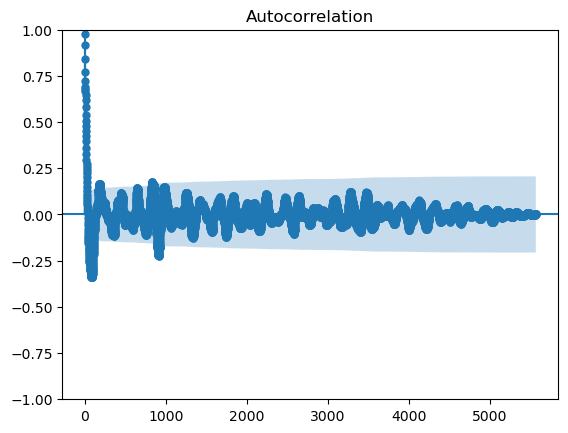

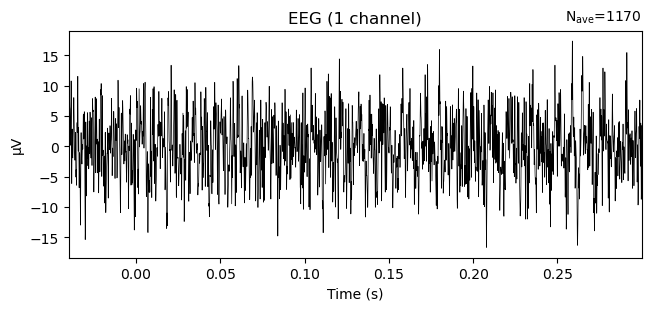

In [50]:
stim_epochs.average().plot();

In [ ]:
stim_data = stim_epochs.average().get_data()[0,:]
active_data = active_grandavg.data[0]
passive_data = passive_grandavg.data[0]

In [78]:
np.array(range(len(stim_data)))

array([   0,    1,    2, ..., 5568, 5569, 5570])

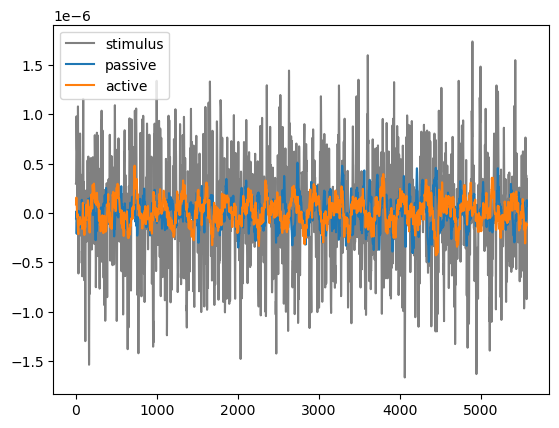

In [86]:
plt.plot(stim_data/10, color='grey')
plt.plot(passive_data)
plt.plot(active_data)
plt.legend(['stimulus','passive','active'])
#plt.xaxis(np.array(range(len(stim_data)))/16384)
plt.show()

In [52]:
from scipy.stats import spearmanr
active_res = spearmanr(active_data, stim_data, alternative='greater')
passive_res = spearmanr(passive_data, stim_data, alternative='greater')


In [ ]:
active_res

In [ ]:
passive_res